<a href="https://colab.research.google.com/github/carlocamilloni/MAGROS/blob/master/MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Dynamics simulation with GROMACS

The goal of this experience is to run some Molecular Dynamics simulations of simple system and analyze them, in particular we will focus on water and alanine dipeptide

## Preliminary setup stuff

In [ ]:
# mount google drive  
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# install gromacs
!apt update
!apt-get install gromacs

In [ ]:
# test the gromacs executable
!gmx

In [ ]:
!git clone https://github.com/carlocamilloni/Structural-Bioinformatics.git sb

In [ ]:
# set the path to your local task folder
local_path='/content/drive/MyDrive/Task5'
%cd {local_path}

All GROMACS tools are modules of a binary named "gmx". To get help about any GROMACS module, you can invoke either of the following commands:

gmx help (module)

or

gmx (module) -h

where (module) is replaced by the actual name of the command you're trying to issue. A full list of GROMACS modules can be printed by

gmx help commands

###Units

Basic units in GROMACS are 

Time: ps

Space: nm

Energy: kJ/mol


## Molecular Dynamics of a water box

In the following you will setup a MD simulation of a small water box and calculate some water property:

### system preparation

In [ ]:
# copy a water box file with 216 molecules in a cubic box:
%cd {local_path}
%mkdir water
%cd water
%cp /usr/share/gromacs/top/spc216.gro .

The first step is to generate the

*   Starting coordinates file
*   Topology file that includes the choice of the force field

this is done in gromacs using the tool `pdb2gmx`:

In [ ]:
# here we are using amber03 as a force field and spce as the water model:
!gmx pdb2gmx -f spc216.gro -ff amber03 -water spce

In [ ]:
ls

There should be two new files: 

* conf.gro: starting coordinates in gromacs format
* topol.top: topology file including relevant parameters and force-field choice.

If you open topol.top (these are all text files) you can see that is very simple in this case.

In principle now we should generate the box, but in this case we are already starting from a box of water molecules, you can see the box size at the bottom of the conf.gro file:

In [ ]:
!tail conf.gro

box: 1.86206   1.86206   1.86206

This means that is a cubic box of side 1.862 etc

### energy minimization:

In [ ]:
# to perform simulations we also need a simulation parameter file
!cp /content/drive/MyDrive/sb/md/mdps/0-em-steep.mdp .

In [ ]:
#then we need to generate a simulation package file that put togheter the starting configuration, the topology and the simulation parameter file:
!gmx grompp -f 0-em-steep.mdp -c conf.gro -p topol.top -o em.tpr

In [ ]:
#run the energy minimization:
!gmx mdrun -s em.tpr -v

### MD

In [ ]:
#now we are ready to setup the first simple MD
!cp ../sb/md/mdps/npt-water.mdp .

In [ ]:
%cd {local_path}
#look into the paramter file, can you find 
# how long is it?
# at which temperature and pressure we are gonna running it?
!cat npt-water.mdp 

In [ ]:
#preparation
!gmx grompp -f npt-water -c confout -p topol -o md-water.tpr

In [ ]:
!gmx mdrun -v -deffnm md-water

### Visualisation

Once the simulation is ended you should have few more files:

In [ ]:
%ls

*   md-water.xtc: trajectory file
*   md-water.edr: energy file including all the information about energy
*   md-water.gro: last frame of the trajectory
*   md-water.cpt: checkpoint file for exact restart

You can look at the trajectory using VMD on your laptop, first load a `conf.gro` then from the menu FILE chose Load Data Into Molecule and select the `md-water.xtc` file, this will add all the trajectory frames. You may see something like this:

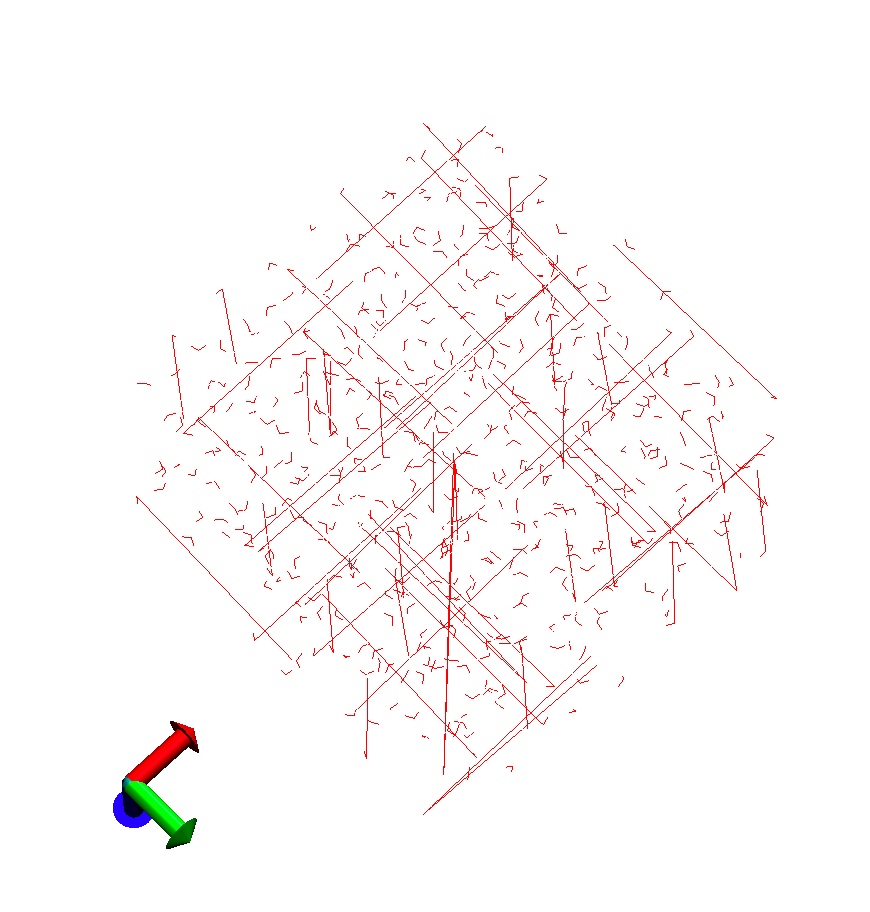

You remember the “PERIODIC BOUNDARY CONDITIONS”? A molecule of water can be cut across the sides of the box. For the purpose of visualisation, we can remove this effect:

In [ ]:
!echo -e "0\n" | gmx trjconv -f md-water.xtc -s md-water.tpr -pbc mol -o md-water-nobpc.xtc

This command is a bit complicated because the notebooks are not interactive so if we need to select an option, we need to tell it to the program as above:

`echo -e “0\n” |` -> this means after the program that follow is started press “0”.

Anyway, now you have one more file `md-water-nopbc.xtc` that is the trajectory with molecules that are not broken across PBC. Close VMD and reopen it. Now we can start to analyse the trajectory

### Analysis

**DENSITY**, to calculate the density and many other properties we can again use a GROMACS module:



In [ ]:
!echo -e "7\n9\n16\n18\n" | gmx energy -f md-water.edr -nmol 256 -fluct_props -driftcorr


This will generate a file named `energy.xvg` with as many columns as the properties selected. Here:
`-nmol 256` indicates how many molecules are in the simulations
`-fluct_props` tell the program to calculate fluctuations (see my slides on how to calculate some of the resulting properties).

This will calculate the density over time, total energy, enthalpy and temperature and derive simple properties from it (heat capacity and enthalpy of vaporisation).

Try to generate the plot for all of them and compare the result with the number reported in the tables, be careful about the units.

To plot more than one set in the same plot you can do something like this:

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]
y3=[]
y4=[]

with open('energy.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))
        y2.append(float(row.split()[2]))
        y3.append(float(row.split()[3]))
        y4.append(float(row.split()[4]))


# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2,2)
# For Cosine Function

axis[0,0].plot(x, y1)
axis[0,0].set_title("Total Energy")

axis[1,0].plot(x, y2)
axis[1,0].set_title("Temperature")

axis[0,1].plot(x, y3)
axis[0,1].set_title("Density")

axis[1,1].plot(x, y4)
axis[1,1].set_title("Entalphy")

plt.show()


In the table below there are some numbers to compare with, be careful about units:

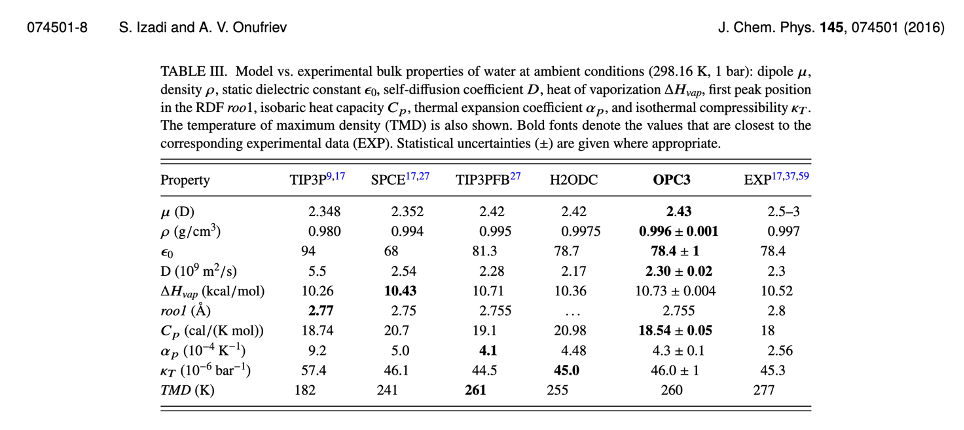

## Molecular Dynamics of Alanine Dipeptide in vacuum

In this task you will first setup and run a simulation of alanine dipeptide in vacuum. This is a very simple system, an alanine with two peptide bonds (ACE-ALA-NME), that is generally used in simulation to test the ability of force-field to reproduce correctly the Ramachandran plot. 

This is alanine-dipeptide:

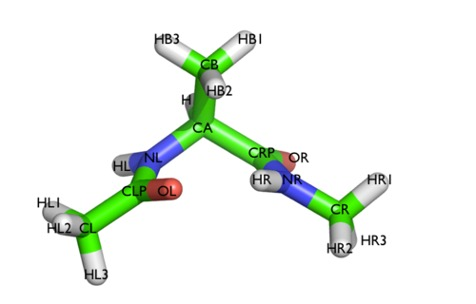

The PDB structure for this system is in MD-examples/alanine-dipeptide, first of all copy the file in your folder. 



In [ ]:
%cd {local_path}
%mkdir aladp
%cd aladp
%cp /content/drive/MyDrive/sb/md/inputs/aladp.pdb .

Now, if you remember the steps for beginning an MD simulations they were more or less:

1)	Chose a force-field 

2)	Setting the box and the solution conditions

3)	Energy minimization

4)	Simulation

So, from the beginning, the first step is to “translate” the PDB structure in the GROMACS format, while at the same time we set the force-field. This is done interactively using the GROMACS module `pdb2gmx`, here we chose the first force field in the list and we don’t choose any specific model of water because we will run the simulation in vacuum:

### System preparation

In [ ]:
!gmx pdb2gmx -f aladp.pdb -water none -ff amber03

From the output you will see that we have selected the force field “AMBER03”, you can also see some information about the system.

Now in the folder you have some more files:

-	conf.gro: the alanine dipeptide structure in the gromacs format
-	topol.top: a topology file including all the information about the force field
-	posre.itp: this is a file that can be used to restrain the position of the atoms (we will not use it).

Now moving to the second step we need to define the BOX of our simulation


In [ ]:
!gmx editconf -f conf.gro -bt cubic -d 1 -o boxed.gro

We are putting our molecule in a cubic box whose side are at least 1 nm far from the surface of our molecule. boxed.gro is the resulting output file.

At this point one would fill the box with the solution, but we are working in vacuum so we skip this step.

So we prepare the system for energy minimization:


### Energy minimisation

In [ ]:
%cp /content/drive/MyDrive/sb/md/mdps/0-em-steep.mdp em.mdp

In [ ]:
!gmx grompp -f em.mdp -c boxed.gro -p topol.top -o em.tpr
!gmx mdrun -deffnm em -v

The first command merges all the information of the em.mdp, boxed.gro and topol.top files into a single file that will be used to run the simulation: em.tpr. In the file em.mdp there are all the details about the simulation algorithms.

The second command executes the energy minimization, this lasts only few steps


Now there is a em.gro file that is the energy minimized structure:

### Molecular dynamics

In [ ]:
%cd {local_path}/aladp
%cp /content/drive/MyDrive/sb/md/mdps/run.mdp .

In [ ]:
!gmx grompp -f run.mdp -c em.gro -p topol.top -o run.tpr
!gmx mdrun -deffnm run -v -nb cpu -ntmpi 1 -ntomp 1

### Visualisation

The simulation will take around 1 minute to perform 10 ns.

To visualise the simulation, you can copy the `run.xtc` and `em.gro` files on your workstation. Open the `em.gro` file with VMD and then load into the `run.xtc` file.

### Analysis

In [ ]:
!gmx chi -f run.xtc -s run.tpr -phi -psi -rama -all

In [ ]:
%ls

This will write a `psiALA2.xvg` and `phiALA2.xvg` files that include the time evolution of the phi and psi angles:

You can plot both as a function of the frame 


In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]

with open('phiALA2.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

with open('psiALA2.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        y2.append(float(row.split()[1]))

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2)

axis[0].plot(y1)
axis[0].set_title("PHI")

axis[1].plot(y2)
axis[1].set_title("PSI")

plt.show()


or one against the other as in the Ramachandran plot:

In [ ]:

import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]

with open('ramaPhiPsiALA2.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

plt.scatter(x,y1)
plt.title('')

plt.xlabel('')
plt.ylabel('')

plt.show()


There are also histograms:

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]

with open('histo-phiALA.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '&':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

with open('histo-psiALA.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '&':
          continue
        if row.split()[0] == '@TYPE':
          continue
        y2.append(float(row.split()[1]))


figure, axis = plt.subplots(2)

axis[0].plot(x,y1)
axis[0].set_title("PHI")

axis[1].plot(x,y2)
axis[1].set_title("PSI")

plt.show()